In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gdp
from matplotlib import interactive
import seaborn as sns
plt.style.use('bmh')
interactive(True)
from datetime import datetime as dt
from matplotlib.animation import FuncAnimation
import numpy as np
from shapely import geometry
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(color_codes=True)

In [3]:
df_dist = gdp.read_file('/Users/tjspross/Downloads/layer0_0/')
df_dist = df_dist.to_crs({'init': 'epsg:4326'})
df_dist_d = gdp.read_file('/Users/tjspross/Downloads/layer0_0_dense/')
df_dist_d = df_dist_d.to_crs({'init': 'epsg:4326'})
df_dist_c = gdp.read_file('/Users/tjspross/Downloads/layer0_0_central/')
df_dist_c = df_dist_c.to_crs({'init': 'epsg:4326'})

df_natline = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/natural_line.shp')
df_bound_line = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_line.shp')
df_highway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/highway_line.shp')
df_waterway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/waterway_polygon_polygon.shp')
df_bound_poly = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_polygon_polygon.shp')
df_bound_poly = df_bound_poly.loc[df_bound_poly['BOUNDARY']!='protected_area']
df_bound_poly = df_bound_poly.loc[df_bound_poly['ADMIN_LEVE']=='6']
# df_dist_d.TITLE
# df_dist_d.head(15)

In [ ]:
plot_highway = df_highway.loc[df_highway['HIGHWAY'].isin(['primary','secondary','tertiary'])].plot(color='gray', figsize=(20,20))
plot_bound_poly = df_bound_poly.plot(legend = True,figsize=(20,20),column='NAME:EN',cmap='viridis',ax =plot_highway)
plot = df_waterway.plot(figsize=(20,20),color='lightblue',ax=plot_bound_poly)

plot.xaxis.set_ticks(np.arange(121.4, 121.52, 0.005))
plot.yaxis.set_ticks(np.arange(31.18, 31.26, 0.005))
plot.set_xlim([121.4, 121.52])
plot.set_ylim([31.18, 31.26])

In [ ]:
plot_highway = df_highway.loc[df_highway['HIGHWAY'].isin(['primary','secondary','tertiary'])].plot(color='gray', figsize=(20,20))
plot_bound_poly = df_dist.plot(legend=True,cmap='viridis',column='TITLE',figsize=(20,20),ax =plot_highway)
plot = df_waterway.plot(figsize=(20,20),color='lightblue',ax=plot_bound_poly)

plot.set_xlim([121.4, 121.52])
plot.set_ylim([31.18, 31.26])
# plot.xaxis.set_ticks(np.arange(121.4, 121.52, 0.005))
# plot.yaxis.set_ticks(np.arange(31.18, 31.26, 0.005))


In [4]:
df = pd.read_json("/Users/tjspross/Documents/scrapy_smartshanghai/housing.json",lines=True)
# remove null or missing values
df = df.loc[~df['title'].isnull()]
df.loc[df['rooms']!='']

# filter by apartment types
df = df.loc[df['posted_type'].isin(['Apartment for rent','Shared apartment','House for rent','Service Apartment'])]

# truncate publish_time column into dates and months
df['publish_date'] = df['publish_time'].dt.date
df['publish_month'] = pd.to_datetime(dict(year=df['publish_time'].dt.year, month=df['publish_time'].dt.month, day=1))
df['pub_month'] = df['publish_month'].dt.month
df['publish_week']=(df['publish_time'] - pd.to_timedelta(df['publish_time'].dt.dayofweek, unit='d')).dt.date
# show dataframe

#create rooms columns
df['rooms'] = df['rooms'].str.replace(', [0-9]* Storage','').str.strip()
df.loc[df['rooms']=='']
df['rooms_BR'] = df['rooms'].str.extract('([0-9]*) Bedroom',0).fillna(0).astype('int')
df['rooms_BA'] = df['rooms'].str.extract('.*, ([0-9]*) Bathroom',0).fillna(0).astype('int')

df['rooms_simple'] = df['rooms_BR'].astype('str') + "BR, "+ df['rooms_BA'].astype('str') + "BA"

# filter for prices like 10,000 RMB or 10,000 rmb or 10,000 or RMB10,000
df = df.loc[df['price'].str.contains('^[0-9,]{3,} RMB$|^[0-9,]{3,} rmb$|^[0-9,]{3,}$|^RMB[0-9,]{3,}$')]
# strip unnecessary characters and convert to int
df['price']=df['price'].str.replace('RMB', '', case=True).str.replace(',','').str.strip().astype('int')


# remove sublets that appear in 'Apartments for rent'
sublets = df.loc[(df['description'].str.contains('overtake|leaving|take over|sublet|roommate|roomate|bedroom available')) & 
             (df['posted_type']=='Apartment for rent') &
            (df['rooms_BR']>=2) &
            (df['price']<10000)][['description','price','rooms','posted_type']]
sublets2= df.loc[(df['rooms_BR']>=3) & (df['price']<=5000) & (df['posted_type']=='Apartment for rent')]

df = df.loc[~df.index.isin(sublets2.index)]
df = df.loc[~df.index.isin(sublets.index)]

for i in xrange(0,4):
    # filtering out top 2% apartments and bottom 1%
    upper_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.99)
    lower_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.01)
    df = df.loc[~((df['price']>upper_lim) & (df['rooms_BR']==i))]
    df = df.loc[~((df['price']<lower_lim) & (df['rooms_BR']==i))]
    
# Define columns
main_cols = ['area','author','description','floor','latitude',
             'longitude','listing_id','posted_type','price','publish_time','rooms','size','title']
checkbox_cols = ['air_filter','central_aircon','balcony','dryer','dvd_player','elevator',
                 'floor_heating','health_club','outdoor_space','oven','parking','playground','pool',
                'security','tv','wall_heating','washing_machine','water_filter']

# Show weeks in which we pulled the most data
weeks = df['publish_week'].value_counts()[0:6].index
weeks = weeks.sort_values()

df = df.loc[df['longitude'].astype('str')!='']
df = df.loc[df['latitude'].astype('str')!='']


In [5]:
def checkarea(value,geoDataFrame):
    area = geoDataFrame.loc[geoDataFrame['geometry'].contains(geometry.Point(value[0],value[1]))]['TITLE']
    if area.empty:
        return None
    else:
        return area.tolist()[0]
# df['district'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist,),axis=1)
df['district_dense'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_d,),axis=1)
df['district_central'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_c,),axis=1)

In [6]:
def makegeoseris(value):
    return geometry.Point(value[0],value[1])
df['geometry']=df[['longitude','latitude']].astype('float').apply(makegeoseris,axis=1)
dfgeo = gdp.GeoDataFrame(df)

In [8]:
def count_points(geoDataframe,groupby_col=None,output_col=None):
    counts=pd.DataFrame(geoDataframe.loc[~geoDataframe[groupby_col].isnull()][groupby_col].value_counts())
    counts.columns=[output_col]
    counts['TITLE']=counts.index
    counts.set_index("TITLE")
    return counts[output_col]
df_dist_d = df_dist_d.filter(regex='^(?!count)')
df_dist_c = df_dist_c.filter(regex='^(?!count)')
if df_dist_c.filter(regex='count').empty:
    df_dist_c = df_dist_c.join(count_points(dfgeo,'district_central','count'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==1],'district_central','count_1br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==2],'district_central','count_2br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==3],'district_central','count_3br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==4],'district_central','count_4br'),on='TITLE')
if df_dist_d.filter(regex='count').empty:
    df_dist_d = df_dist_d.join(count_points(dfgeo,'district_dense','count'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==1],'district_dense','count_1br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==2],'district_dense','count_2br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==3],'district_dense','count_3br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==4],'district_dense','count_4br'),on='TITLE')

In [ ]:
df['publish_date'].value_counts().plot()

In [ ]:
df.shape

In [83]:
def agg_price(func,rooms_br=None,groupby_col=None):
    if callable(func):
        func_name=func.__name__
    else:
        func_name=func
    price = pd.DataFrame(dfgeo.loc[
    (dfgeo['rooms_BR']==rooms_br) &
    (~dfgeo['posted_type'].isin(['Shared apartment','Service Apartment']))].groupby(groupby_col).agg(func)['price'])
    colname = "%s_%sbr"% (func_name,rooms_br)
    price.columns=[colname]
    price['TITLE']=price.index
    price[colname + "_text"] = price.apply(lambda x: "{:,.0f} CNY".format(np.round(x[colname]),0), axis=1)
    price=price.set_index('TITLE')
    return price
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def calc_price_cols(geoDataframe,groupby_col=None):
    if geoDataframe.filter(regex='median').empty:
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=4,groupby_col=groupby_col),on='TITLE')
    if geoDataframe.filter(regex='mean').empty:
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=4,groupby_col=groupby_col),on='TITLE')
    if geoDataframe.filter(regex='quant').empty:
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=4,groupby_col=groupby_col),on='TITLE')
    return geoDataframe

df_dist_c = calc_price_cols(df_dist_c.filter(regex='^(?!mean|median|percentile)'),groupby_col='district_central')
df_dist_d = calc_price_cols(df_dist_d.filter(regex='^(?!mean|median|percentile)'),groupby_col='district_dense')

elev = df.groupby('district_dense')['elevator'].agg(['sum','count'])
elev['perc_elev'] = elev['sum']/elev['count']
if df_dist_c.filter(regex='perc_elev').empty:
    df_dist_c = df_dist_c.join(elev['perc_elev'],on='TITLE')
if df_dist_d.filter(regex='perc_elev').empty:
    df_dist_d = df_dist_d.join(elev['perc_elev'],on='TITLE')    

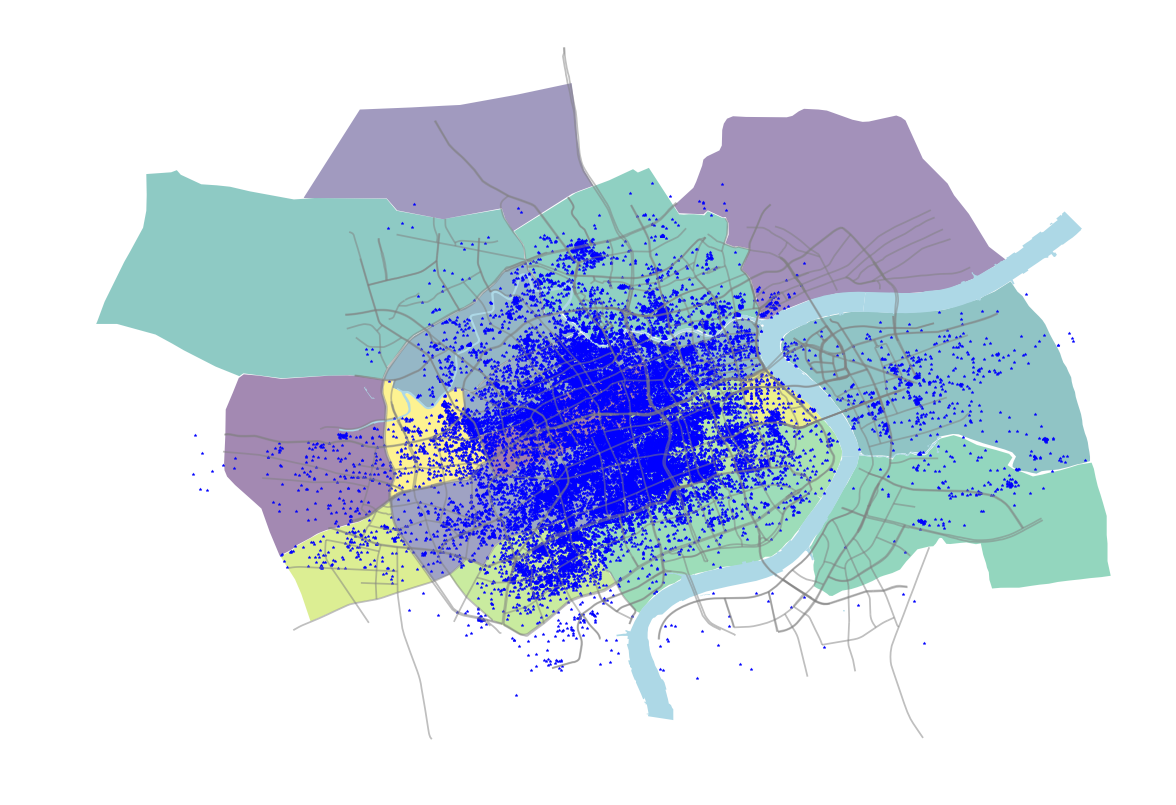

In [132]:
figsize=(20,14)
f, ax = plt.subplots(1,figsize=figsize)
plot_highway = df_highway.loc[df_highway['HIGHWAY'].isin(['primary','secondary','tertiary'])].plot(alpha=0.5,ax=ax,color='gray', figsize=figsize)
plot_dist = df_dist.plot(alpha=0.5,cmap='viridis',column='TITLE',figsize=figsize,ax =plot_highway)
plot_waterway = df_waterway.plot(figsize=figsize,color='lightblue',ax=plot_dist)
dfgeo.loc[~dfgeo['district_dense'].isnull()].plot(ax=plot_waterway,marker='*', color='blue', markersize=10,figsize=figsize)
# ax.set_xlim([121.385, 121.53])
# ax.set_ylim([31.18, 31.265])
ax.set_axis_off()
plt.axis('tight')
# df_custom_dist.apply(lambda x: ax.annotate(s=x.TITLE, xy=x.geometry.centroid.coords[0], ha='center',fontsize=30),axis=1)

plt.show()

## Number of Postings

In [133]:
from bokeh.palettes import viridis,RdBu,Viridis256
from bokeh.models import ColorBar, LogColorMapper
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Category10

geo_source = GeoJSONDataSource(geojson=df_dist_d.to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LinearColorMapper(RdBu[11])

fig = figure(title='Smartshanghai Postings',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>District</b>: @TITLE</div>'
              '<div><b>Number Listings</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
# fig.formatter.use_scientific = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

In [85]:

geo_source = GeoJSONDataSource(geojson=df_dist_d.to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LinearColorMapper(RdBu[11])

fig = figure(title='Apartment Building Likelihood',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'perc_elev', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>District</b>: @TITLE</div>'
              '<div><b>Likelihood</b>: @perc_elev</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
# fig.formatter.use_scientific = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

## Number of Listings Central Vs Not-Central

In [15]:

geo_source = GeoJSONDataSource(geojson=df_dist_c.loc[df_dist_c['TITLE']!='Central Shanghai'].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LinearColorMapper(RdBu[11])

fig = figure(title='Smartshanghai Postings',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>District</b>: @TITLE</div>'
              '<div><b>Number Listings</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
# fig.formatter.use_scientific = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

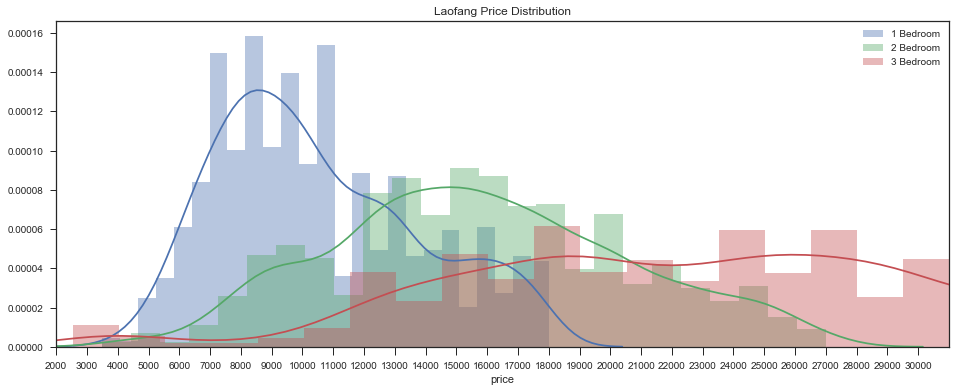

In [127]:
plt.figure(figsize=(16,6))
laofang_dist = df_dist_d.loc[(df_dist_d['perc_elev']<.6) & (df_dist_d['count']>100)]['TITLE']

df_nelev = df.loc[(df['district_dense'].isin(list(laofang_dist))) & (df['elevator']==1)]
df_nelev = df_nelev.loc[df_nelev['price']<df_nelev['price'].quantile(.98)]
sns.distplot(df_nelev.loc[df_nelev['rooms_BR']==1]['price'],bins=25,label='1 Bedroom')
sns.distplot(df_nelev.loc[df_nelev['rooms_BR']==2]['price'],bins=25,label='2 Bedroom')
sns.distplot(df_nelev.loc[df_nelev['rooms_BR']==3]['price'],bins=25,label='3 Bedroom')
plt.title("Laofang Price Distribution")
plt.xticks(np.arange(2000,31000,1000))
plt.xlim(2000,31000)
plt.legend()
plt.show()

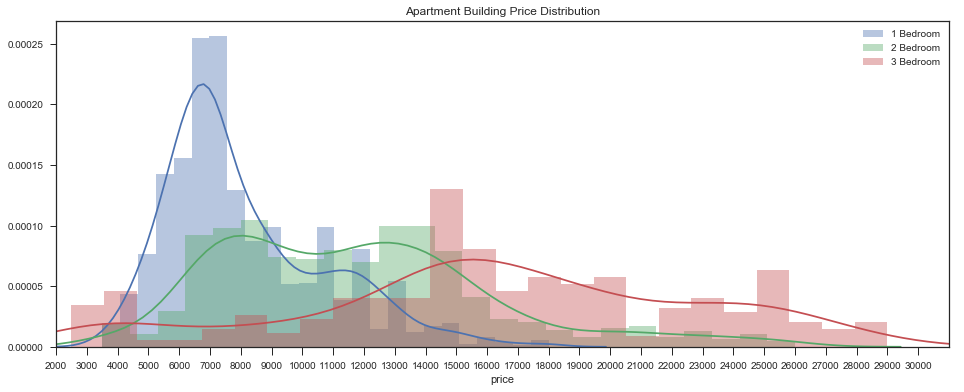

In [123]:
plt.figure(figsize=(16,6))
apt_dist = df_dist_d.loc[(df_dist_d['perc_elev']>=.6) & (df_dist_d['count']>100)]['TITLE']

df_elev = df.loc[(df['district_dense'].isin(list(apt_dist))) & (df['elevator']==0)]
df_elev = df_elev.loc[df_elev['price']<df_elev['price'].quantile(.98)]
sns.distplot(df_elev.loc[df_elev['rooms_BR']==1]['price'],bins=25,label='1 Bedroom')
sns.distplot(df_elev.loc[df_elev['rooms_BR']==2]['price'],bins=25,label='2 Bedroom')
sns.distplot(df_elev.loc[df_elev['rooms_BR']==3]['price'],bins=25,label='3 Bedroom')
plt.title("Apartment Building Price Distribution")
plt.legend()
plt.xticks(np.arange(2000,31000,1000))
plt.xlim(2000,31000)
plt.show()


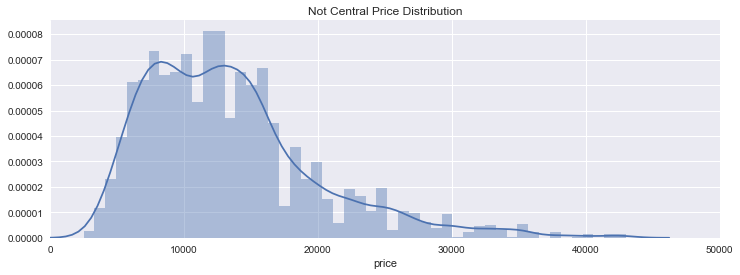

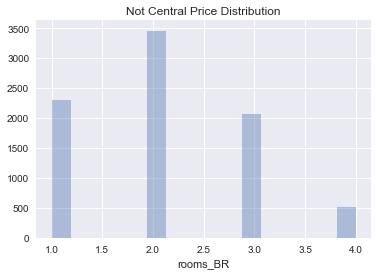

In [39]:
plt.figure(figsize=(12,4))
df_ncentral = df.loc[((df['district_central']!='Central Shanghai') | (df['district_central'].isnull())) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]
df_ncentral = df_ncentral.loc[df_ncentral['price']<df_ncentral['price'].quantile(.99)]
sns.distplot(df_ncentral['price'],bins=50)
plt.title("Not Central Price Distribution")
plt.xlim(0,50000)
plt.show()

sns.distplot(df_ncentral.loc[df_ncentral['rooms_BR'].isin([1,2,3,4])]['rooms_BR'],kde=False)
plt.title("Not Central Price Distribution")
plt.show()

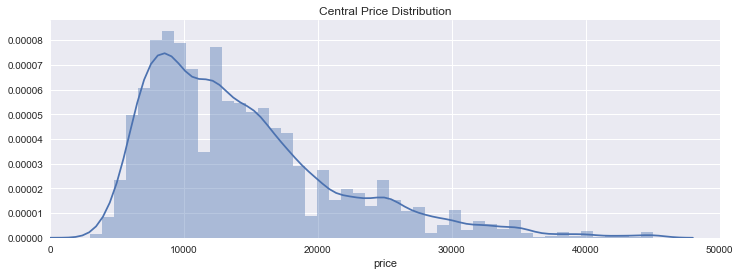

In [27]:
plt.figure(figsize=(12,4))
df_central = df.loc[(df['district_central']=='Central Shanghai')& (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]
df_central = df_central.loc[df_central['price']<df_central['price'].quantile(.99)]
sns.distplot(df_central['price'],bins=50)
plt.title("Central Price Distribution")
plt.xlim(0,50000)
plt.show()

## Average 1 Bedroom Price

In [ ]:

# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Average 1 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_1br']>=25].to_json()), 
            color={'field': 'mean_1br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_1br']<25].to_json()), 
            color='lightgray', 
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])


hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Avg 1BR Price','@mean_1br_text'),
             ('',''),
#               ('10th Percentile','@percentile_10_1br_text'),
#               ('25th Percentile','@percentile_25_1br_text'),
#              ('50th Percentile','@median_1br_text'),
#              ('75th Percentile','@percentile_75_1br_text'),
#              ('90th Percentile','@percentile_90_1br_text'),
             ('Number Listings','@count_1br')
             ]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

## Average 2 Bedroom Price

In [ ]:

# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Average 2 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_2br']>=55].to_json()), 
            color={'field': 'mean_2br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_2br']<50].to_json()), 
            color='lightgray', 
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])


hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Avg 2BR Price','@mean_2br_text'),
             ('',''),
                          ('Number Listings','@count_2br')]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

### Average 3 Bedroom Price

In [ ]:

# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Average 3 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_3br']>=50].to_json()), 
            color={'field': 'mean_3br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_3br']<50].to_json()), 
            color='lightgray', 
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])


hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Avg 3BR Price','@mean_3br_text'),
             ('',''),
             ('Number Listings','@count_3br')]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

## Average 4 Bedroom Price

In [ ]:

# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Average 4 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_4br']>=50].to_json()), 
            color={'field': 'mean_4br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count_4br']<50].to_json()), 
            color='lightgray', 
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Avg 4BR Price','@mean_4br_text'),
             ('',''),
             ('Number Listings','@count_4br')]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

In [ ]:
df = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/highway_line.shp')
# df = df.loc[df['BOUNDARY']!='protected_area']
ax = df.plot(figsize=(20,20),column='NAME:EN',cmap='viridis')
ax.set_xlim([121.4, 121.52])
ax.set_ylim([31.18, 31.26])
df.head()
# df.loc[df['BOUNDARY']!='protected_area'].head()
# df.head(100)
dfhw['HIGHWAY'].value_counts()

In [ ]:
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment

# del states["HI"]
# del states["AK"]

EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]

county_xs=[counties[code]["lons"] for code in counties if counties[code]["state"] not in EXCLUDED]
county_ys=[counties[code]["lats"] for code in counties if counties[code]["state"] not in EXCLUDED]

colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]

county_colors = []

In [ ]:
i=0
while i<10:
    for a in counties:
        print a
        i+=1

In [ ]:
counties[(12, 129)]

In [ ]:
for county_id in counties:
    if counties[county_id]["state"] in EXCLUDED:
        continue
    try:
        rate = unemployment[county_id]
        idx = int(rate/6)
        county_colors.append(colors[idx])
    except KeyError:
        county_colors.append("black")

p = figure(title="US Unemployment 2009", toolbar_location="left",
           plot_width=1100, plot_height=700)

p.patches(county_xs, county_ys,
          fill_color=county_colors, fill_alpha=0.7,
          line_color="white", line_width=0.5)

p.patches(state_xs, state_ys, fill_alpha=0.0,
          line_color="#884444", line_width=2, line_alpha=0.3)

output_file("choropleth.html", title="choropleth.py example")

show(p)

In [ ]:
unemployment[(26, 157)]